In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import admix
import matplotlib.pyplot as plt
from utils import *
import dask
import dask.array as da
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
from admix.data import quantile_normalize

In [2]:
def impute_dataset(vcf, region, dset):
    """
    Given a vcf file and a region, impute the local ancestry information
    from dset (xr.Dataset), typically with SNPs in lower density

    vcf: path to the vcf file
    region: regions of vcf of interest
    dset: existing dataset
    """
    
    region_chrom, region_start, region_stop = [int(i) for i in region.replace("chr", "").replace(":", "-").split("-")]
    dset = dset.sel(
        snp=(dset["CHROM@snp"] == region_chrom)
        & (region_start - 1e6 <= dset["POS@snp"])
        & (dset["POS@snp"] <= region_stop + 1e6)
    )

    vcf = allel.read_vcf(vcf, region=region, fields=['samples', 'calldata/GT', 'variants/*'])
    if region.startswith("chr"):
        vcf["variants/CHROM"] = np.array([int(c[3:]) for c in vcf["variants/CHROM"]])
    # assume no missing data for now
    gt = vcf["calldata/GT"]
    assert (gt == -1).sum() == 0

    dset_imputed = xr.Dataset(
        data_vars={
            "geno": (("indiv", "snp", "ploidy"), da.from_array(np.swapaxes(gt, 0, 1),  chunks=-1)),
        },
        coords={
            "snp": vcf["variants/ID"].astype(str),
            "indiv": vcf["samples"].astype(str),
            "CHROM@snp": ("snp", vcf["variants/CHROM"].astype(int)),
            "POS@snp": ("snp", vcf["variants/POS"].astype(int)),
            "REF@snp": ("snp", vcf["variants/REF"].astype(str)),
            "ALT@snp": ("snp", vcf["variants/ALT"][:, 0].astype(str)),
            "R2@snp": ("snp", vcf["variants/R2"].astype(float)),
            "MAF@snp": ("snp", vcf["variants/MAF"].astype(float))
        },
        attrs={"n_anc": 2},
    )
    dset_imputed = dset_imputed.sel(indiv=dset.indiv.values)

    # fill in individual information
    for col in dset:
        if col.endswith("@indiv"):
            if col in dset_imputed:
                assert np.all(dset[col] == dset_imputed[col])
            else:
                dset_imputed[col] = ("indiv", dset[col].values)

    # impute local ancestry

    # relevant typed region
    typed_start = np.where(dset["POS@snp"] < dset_imputed["POS@snp"][0])[0][-1]
    typed_stop = np.where(dset["POS@snp"] > dset_imputed["POS@snp"][-1])[0][0]
    dset_typed_subset = dset.isel(snp=slice(typed_start, typed_stop + 1))
    dset_typed_margin = dset_typed_subset.isel(snp=[0, -1])

    imputed_lanc = []
    for ploidy_i in range(2):
        df_typed_margin = pd.DataFrame(
            dset_typed_margin.lanc[:, ploidy_i].values.T,
            columns=dset_typed_margin.indiv.values,
            index=dset_typed_margin.snp.values,
        )
        df_imputed = pd.DataFrame(
            {
                "snp": dset_imputed.snp["snp"],
            }
        ).set_index("snp")
        df_imputed = pd.concat(
            [
                df_imputed,
                pd.DataFrame(columns=dset_imputed["indiv"].values, dtype=float),
            ]
        )
        # fill margin
        df_imputed = pd.concat(
            [df_typed_margin.iloc[[0], :], df_imputed, df_typed_margin.iloc[[-1], :]],
            axis=0,
        )
        df_imputed.index.name = "snp"
        # fill inside
        df_imputed.loc[
            dset_typed_subset.snp.values, dset_typed_subset.indiv.values
        ] = dset_typed_subset["lanc"][:, :, ploidy_i].values.T
        # interpolate
        df_imputed = (
            df_imputed.reset_index().interpolate(method="nearest").set_index("snp")
        )

        imputed_lanc.append(
            df_imputed.loc[dset_imputed["snp"].values, dset_imputed["indiv"].values]
            .values.astype(np.int8)
            .T
        )

    dset_imputed = dset_imputed.assign(
        lanc=(("indiv", "snp", "ploidy"), da.from_array(np.dstack(imputed_lanc), chunks=-1))
    )
    
    
    return dset_imputed

In [3]:
trait = "total_wbc_cnt"

In [4]:
dset = load_hm3()
dset = dset.isel(indiv=~np.isnan(dset[f"{trait}@indiv"].values))
assoc = pd.read_csv(f"out/plink_assoc/assoc.{trait}.glm.linear", delim_whitespace=True)
dset[f"{trait}_quantile_normalized@indiv"] = ("indiv", quantile_normalize(dset[f"{trait}@indiv"].values))
study_dummies = pd.get_dummies(dset["study@indiv"], drop_first=True)
for c in study_dummies:
    dset[f"study_dummy_{c}@indiv"] = ("indiv", study_dummies[c])
study_dummy_cols = [f"study_dummy_{c}" for c in study_dummies]

# 
# /u/project/sgss/PAGE/ImputedGWAS_topmedfrz8/MEGA_all.chr1.filtered.vcf.gz
dset_imputed = impute_dataset(vcf="/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/s01_dataset/all/chr1.vcf.gz",
                               region="1:158369116-159808909",
#                               region="chr1:158369116-158408909",
                               dset=dset)

100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [5]:
# APOE
# np.where((assoc["#CHROM"] == 19) & (assoc["POS"] >= 44905791) & (assoc["POS"] <= 44909393))

# DARC
np.where((assoc["#CHROM"] == 1) & (assoc["POS"] >= 159203307) & (assoc["POS"] <= 159206500))

(array([49368, 49369, 49370, 49371]),)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

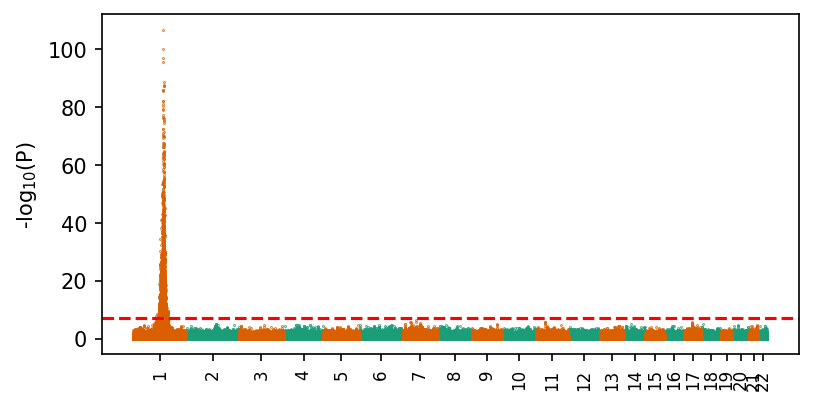

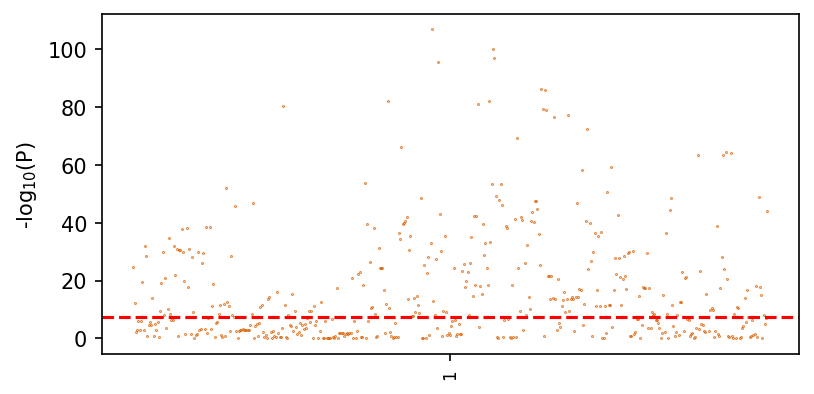

In [6]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
admix.plot.manhattan(pval=assoc["P"].values, chrom=assoc["#CHROM"].values, ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
# DARC
region_index = np.arange(4.91e4, 4.96e4, dtype=int)

# APOE
# region_index = np.arange(97.78e4, 97.8e4, dtype=int)


admix.plot.manhattan(chrom=assoc["#CHROM"].values[region_index], pval=assoc["P"].values[region_index], ax=ax)
fig.show()

In [7]:
cov_cols = ["age", "sex"] + study_dummy_cols + [f"geno_EV{i}" for i in range(1, 11)]
dict_assoc = dict()
for method in ["ATT", "SNP1", "TRACTOR", "ADM"]:
    dict_assoc[method] = admix.assoc.marginal_fast(dset_imputed, 
                                                   pheno=f"{trait}_quantile_normalized@indiv", 
                                                   cov = [c + "@indiv" for c in cov_cols], 
                                                   method=method)
    dset_imputed[f"{method}@snp"] = ("snp", dict_assoc[method].P)

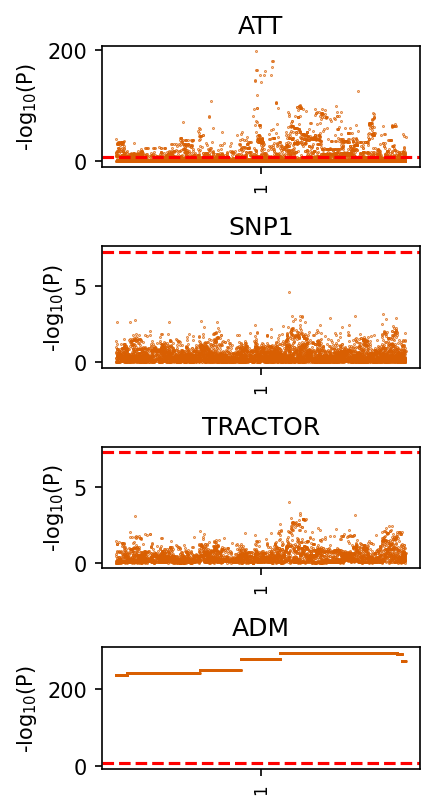

In [8]:
fig, axes = plt.subplots(figsize=(3, 5.5), nrows=4, dpi=150)

for i, method in enumerate(["ATT", "SNP1", "TRACTOR", "ADM"]):
    admix.plot.manhattan(chrom=np.repeat(1, dset_imputed.dims["snp"]), pval=dset_imputed[f"{method}@snp"], ax=axes[i])
    axes[i].set_title(method)
fig.tight_layout()

In [9]:
def ancestry_specific_marginal(dset, pheno, cov):
    """
    Obtain ancestry-specific marginal BETA in a Tractor way
    """
    n_indiv, n_snp = dset.dims["indiv"], dset.dims["snp"]
    design = np.zeros((n_indiv, cov.shape[1] + 2))
    design[:, 2:] = cov
    
    apa = admix.tools.allele_per_anc(dset, inplace=False).compute()
    coef = np.zeros((n_snp, 2))
    stderr = np.zeros((n_snp, 2))
    tvalue = np.zeros((n_snp, 2))

    for snp_i in tqdm(range(n_snp)):
        design[:, 0] = apa[:, snp_i, 0]
        design[:, 1] = apa[:, snp_i, 1]

        model = sm.OLS(
            pheno,
            design,
        ).fit()
        # store results
        coef[snp_i, :] = model.params[0:2]
        stderr[snp_i, :] = model.bse[0:2]
        tvalue[snp_i, :] = model.tvalues[0:2]
    return coef, stderr, tvalue

def ancestry_specific_marginal2(dset, pheno, cov):
    """
    Obtain ancestry-specific marginal BETA in a Tractor way
    """
    n_indiv, n_snp = dset.dims["indiv"], dset.dims["snp"]
    design = np.zeros((n_indiv, cov.shape[1] + 3))
    design[:, 3:] = cov
    
    lanc = np.sum(dset["lanc"].data, axis=2).compute()
    apa = admix.tools.allele_per_anc(dset, inplace=False).compute()
    coef = np.zeros((n_snp, 2))
    stderr = np.zeros((n_snp, 2))
    tvalue = np.zeros((n_snp, 2))

    for snp_i in tqdm(range(n_snp)):
        design[:, 0] = apa[:, snp_i, 0]
        design[:, 1] = apa[:, snp_i, 1]
        design[:, 2] = lanc[:, snp_i]

        model = sm.OLS(
            pheno,
            design,
        ).fit()
        # store results
        coef[snp_i, :] = model.params[0:2]
        stderr[snp_i, :] = model.bse[0:2]
        tvalue[snp_i, :] = model.tvalues[0:2]
    return coef, stderr, tvalue

In [10]:
pheno = quantile_normalize(dset_imputed[f"{trait}_quantile_normalized@indiv"].values)
cov = np.column_stack(
            [np.ones(dset_imputed.dims["indiv"])] + 
            [dset_imputed[col + "@indiv"] for col in ["age", "sex"] + study_dummy_cols + [f"geno_EV{i}" for i in range(1, 11)]])
cov[:, 1:] = (cov[:, 1:] - cov[:, 1:].mean(axis=0)) / cov[:, 1:].std(axis=0)

# coef, stderr, tvalue = ancestry_specific_marginal2(region_dset, pheno, cov)
coef, stderr, tvalue = ancestry_specific_marginal(dset_imputed, pheno, cov)

100%|██████████| 6595/6595 [05:39<00:00, 19.45it/s] 


<ipython-input-11-e73ef34587d0>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope = np.linalg.lstsq(plot_coef[:, 0][:, np.newaxis], plot_coef[:, 1][:, np.newaxis])[0].item()


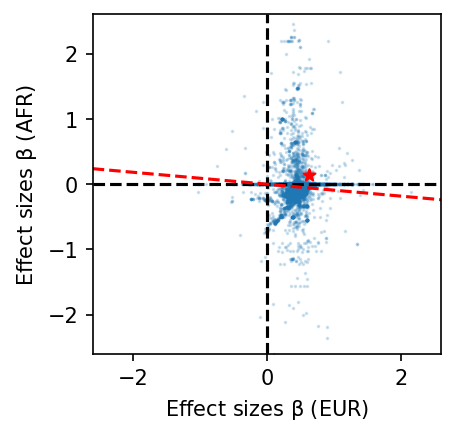

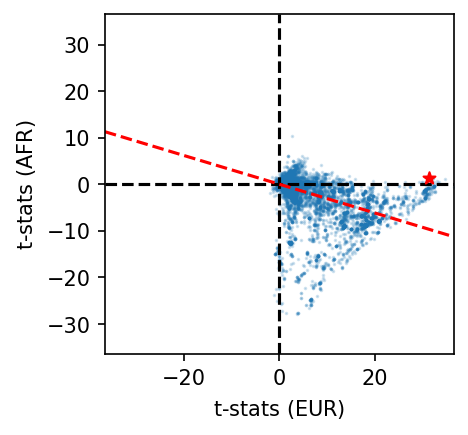

In [11]:
index_snp = dset_imputed["ATT@snp"].argmin().values.item()
for name, plot_coef in zip(["coef", "t-stats"], [coef, tvalue]):
    index_x, index_y = plot_coef[index_snp, :]
    plot_coef = plot_coef[~np.isnan(plot_coef).any(axis=1), :]    
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    lim = np.nanmax(np.abs(plot_coef))
    ax.scatter(plot_coef[:, 0], plot_coef[:, 1], s=0.5, alpha=0.2)
    ax.scatter(index_x, index_y, color='red', alpha=1.0, zorder=10, marker="*")
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.axhline(y=0, color='k', ls='--')
    ax.axvline(x=0, color='k', ls='--')
    slope = np.linalg.lstsq(plot_coef[:, 0][:, np.newaxis], plot_coef[:, 1][:, np.newaxis])[0].item()
    plt.plot([-lim, lim], [-lim * slope, lim * slope], 'r--')
    if name == "coef":
        ax.set_xlabel("Effect sizes $\\beta$ (EUR)")
        ax.set_ylabel("Effect sizes $\\beta$ (AFR)")
    elif name == "t-stats":
        ax.set_xlabel("$t$-stats (EUR)")
        ax.set_ylabel("$t$-stats (AFR)")

In [31]:
admix.tools.af_per_anc(dset_imputed)
admix.tools.allele_per_anc(dset_imputed)

In [77]:
dset_imputed[""]

<xarray.Dataset>
Dimensions:                                  (snp: 6595, indiv: 8889, ploidy: 2, anc: 2)
Coordinates:
  * snp                                      (snp) <U18 'chr1:158369116:C:T' ...
  * indiv                                    (indiv) <U8 '709411' ... '704131'
    CHROM@snp                                (snp) int64 1 1 1 1 1 ... 1 1 1 1 1
    POS@snp                                  (snp) int64 158369116 ... 159808909
    REF@snp                                  (snp) <U1 'C' 'G' 'G' ... 'G' 'G'
    ALT@snp                                  (snp) <U1 'T' 'A' 'A' ... 'T' 'A'
    R2@snp                                   (snp) float64 0.9997 ... 0.9739
    MAF@snp                                  (snp) float64 0.3567 ... 0.158
Dimensions without coordinates: ploidy, anc
Data variables: (12/89)
    geno                                     (indiv, snp, ploidy) int8 dask.array<chunksize=(8889, 6595, 2), meta=np.ndarray>
    crp@indiv                                (indiv) float64 4.02 3.72 ... 5.0
    total_wbc_cnt@indiv                      (indiv) float64 4.5 9.6 ... 5.3 6.4
    mean_corp_hgb_conc@indiv                 (indiv) float64 nan nan ... nan nan
    platelet_cnt@indiv                       (indiv) float64 325.0 ... 246.0
    hdl@indiv                                (indiv) float64 72.0 56.2 ... 52.0
    ...                                       ...
    ATT@snp                                  (snp) float64 4.241e-15 ... 9.83...
    SNP1@snp                                 (snp) float64 0.5187 ... 0.1909
    TRACTOR@snp                              (snp) float64 0.8119 ... 0.2438
    ADM@snp                                  (snp) float64 1.032e-237 ... 1.1...
    allele_per_anc                           (indiv, snp, anc) float64 dask.array<chunksize=(8889, 6595, 2), meta=np.ndarray>
    af_per_anc                               (snp, anc) float64 dask.array<chunksize=(6595, 2), meta=np.ndarray>
Attributes:
    n_anc:    2

In [76]:
dset_imputed["af_per_anc"].values

array([[0.09095861, 0.4245711 ],
       [0.1119281 , 0.00616759],
       [0.07734205, 0.00992485],
       ...,
       [0.19448276, 0.49607857],
       [0.03393103, 0.00127182],
       [0.45186207, 0.08068961]])

In [35]:
dset_imputed.isel(snp=index_snp)["af_per_anc"].values

array([0.80321614, 0.00644978])

In [44]:
dset_tmp = dset_imputed.isel(snp=index_snp)

In [45]:
geno, lanc = dset_tmp.geno.values, dset_tmp.lanc.values

In [58]:
apa = dset_tmp.allele_per_anc.values

In [74]:
geno.mean()

0.17088536393295084

In [65]:
apa.shape

(8889, 2)

In [64]:
apa.mean(axis=0)

array([0.33153336, 0.01023737])

In [73]:
lanc.mean()

0.7936213297333783

In [72]:
geno[lanc == 0].mean()

0.8032161351866993

In [71]:
dset_tmp

<xarray.Dataset>
Dimensions:                                  (indiv: 8889, ploidy: 2, anc: 2)
Coordinates:
    snp                                      <U18 'chr1:159018151:A:G'
  * indiv                                    (indiv) <U8 '709411' ... '704131'
    CHROM@snp                                int64 1
    POS@snp                                  int64 159018151
    REF@snp                                  <U1 'A'
    ALT@snp                                  <U1 'G'
    R2@snp                                   float64 0.9998
    MAF@snp                                  float64 0.1745
Dimensions without coordinates: ploidy, anc
Data variables: (12/89)
    geno                                     (indiv, ploidy) int8 dask.array<chunksize=(8889, 2), meta=np.ndarray>
    crp@indiv                                (indiv) float64 4.02 3.72 ... 5.0
    total_wbc_cnt@indiv                      (indiv) float64 4.5 9.6 ... 5.3 6.4
    mean_corp_hgb_conc@indiv                 (indiv) float64 nan nan ... nan nan
    platelet_cnt@indiv                       (indiv) float64 325.0 ... 246.0
    hdl@indiv                                (indiv) float64 72.0 56.2 ... 52.0
    ...                                       ...
    ATT@snp                                  float64 1.866e-199
    SNP1@snp                                 float64 0.3436
    TRACTOR@snp                              float64 0.6119
    ADM@snp                                  float64 1.092e-278
    allele_per_anc                           (indiv, anc) float64 dask.array<chunksize=(8889, 2), meta=np.ndarray>
    af_per_anc                               (anc) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    n_anc:    2

In [68]:
(lanc == 1).sum()

14109

In [60]:
geno[lanc == 1].sum()

91

In [51]:
lanc

array([[1, 1],
       [1, 0],
       [1, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

In [50]:
lanc.mean()

0.7936213297333783

In [43]:
dset_imputed.isel(snp=index_snp).allele_per_anc.values.mean(axis=0)

array([0.33153336, 0.01023737])

In [29]:
from scipy.stats import ttest_rel

In [30]:
ttest_rel(dset_imputed["af_per_anc"][:, 0], dset_imputed["af_per_anc"][:, 1])

Ttest_relResult(statistic=0.066328979851359, pvalue=0.9471179222759116)

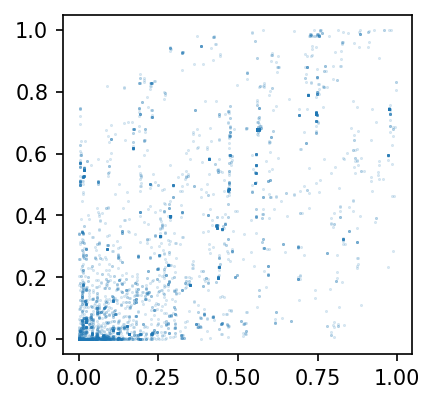

In [28]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(dset_imputed["af_per_anc"][:, 0], dset_imputed["af_per_anc"][:, 1], s=0.2, alpha=0.2)

In [20]:
dset_imputed["af_per_anc"]

<xarray.DataArray 'af_per_anc' (snp: 6595, anc: 2)>
dask.array<transpose, shape=(6595, 2), dtype=float64, chunksize=(6595, 2), chunktype=numpy.ndarray>
Coordinates:
  * snp        (snp) <U18 'chr1:158369116:C:T' ... 'chr1:159808909:G:A'
    CHROM@snp  (snp) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    POS@snp    (snp) int64 158369116 158369504 158369518 ... 159808821 159808909
    REF@snp    (snp) <U1 'C' 'G' 'G' 'G' 'T' 'C' 'C' ... 'A' 'T' 'C' 'A' 'G' 'G'
    ALT@snp    (snp) <U1 'T' 'A' 'A' 'A' 'C' 'G' 'T' ... 'G' 'C' 'T' 'G' 'T' 'A'
    R2@snp     (snp) float64 0.9997 0.9607 0.9954 ... 0.9858 0.9818 0.9739
    MAF@snp    (snp) float64 0.3567 0.02836 0.02383 ... 0.4302 0.00779 0.158
Dimensions without coordinates: anc

In [17]:
dset_imputed["allele_per_anc"].

<xarray.DataArray 'allele_per_anc' (indiv: 8889, snp: 6595, anc: 2)>
dask.array<lambda, shape=(8889, 6595, 2), dtype=float64, chunksize=(8889, 6595, 2), chunktype=numpy.ndarray>
Coordinates:
  * indiv      (indiv) <U8 '709411' '791264' '785682' ... '716349' '704131'
  * snp        (snp) <U18 'chr1:158369116:C:T' ... 'chr1:159808909:G:A'
    CHROM@snp  (snp) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    POS@snp    (snp) int64 158369116 158369504 158369518 ... 159808821 159808909
    REF@snp    (snp) <U1 'C' 'G' 'G' 'G' 'T' 'C' 'C' ... 'A' 'T' 'C' 'A' 'G' 'G'
    ALT@snp    (snp) <U1 'T' 'A' 'A' 'A' 'C' 'G' 'T' ... 'G' 'C' 'T' 'G' 'T' 'A'
    R2@snp     (snp) float64 0.9997 0.9607 0.9954 ... 0.9858 0.9818 0.9739
    MAF@snp    (snp) float64 0.3567 0.02836 0.02383 ... 0.4302 0.00779 0.158
Dimensions without coordinates: anc

In [13]:
snp_dset = dset_imputed.sel(snp="chr1:159117196:G:A")

In [14]:
cov = np.column_stack(
            [np.ones(snp_dset.dims["indiv"])] + 
            [snp_dset[col + "@indiv"] for col in ["age", "sex"] + study_dummy_cols + [f"geno_EV{i}" for i in range(1, 11)]])
cov[:, 1:] = (cov[:, 1:] - cov[:, 1:].mean(axis=0)) / cov[:, 1:].std(axis=0)
model = sm.OLS(snp_dset[f"{trait}_quantile_normalized@indiv"].values,
       cov).fit()

In [15]:
df_plot = pd.DataFrame({"pheno": model.resid, 
                        "lanc": snp_dset.lanc.values.sum(axis=1), 
                        "geno": snp_dset.geno.values.sum(axis=1),
                        "eur_geno": snp_dset.allele_per_anc[:, 0].compute(),
                        "afr_geno": snp_dset.allele_per_anc[:, 1].compute()})

In [20]:
df_plot.corr()

,pheno,lanc,geno,eur_geno,afr_geno
pheno,1.000000,-0.308159,0.216309,0.255913,-0.025492
lanc,-0.308159,1.000000,-0.651787,-0.794002,0.115758
geno,0.216309,-0.651787,1.000000,0.850878,0.447611
eur_geno,0.255913,-0.794002,0.850878,1.000000,-0.088933
afr_geno,-0.025492,0.115758,0.447611,-0.088933,1.000000


pheno~lanc (0.25591251254705727, 6.398122640655725e-133)


(-0.5, 2.5)

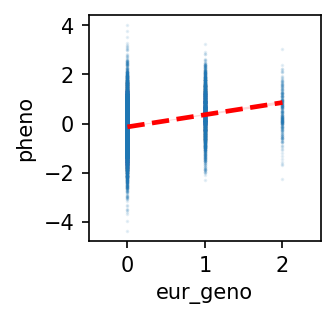

In [21]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
sns.regplot(data=df_plot, x="eur_geno", y="pheno", ci=95, scatter_kws={"s": 0.5, "alpha": 0.1}, line_kws={"color": "red", "ls": '--'})
print("pheno~lanc", pearsonr(df_plot.eur_geno, df_plot.pheno))
ax.set_xlim(-0.5, 2.5)

pheno~lanc (-0.3081594045843053, 7.706088555995815e-195)
pheno~geno (0.21630870154206575, 1.309453540877858e-94)
lanc=0: pheno~geno (0.06919873973966104, 0.10659544024543847)
lanc=1: pheno~geno (0.02817548718922271, 0.15258785640257946)
lanc=2: pheno~geno (0.003933869507914329, 0.7652256964074676)


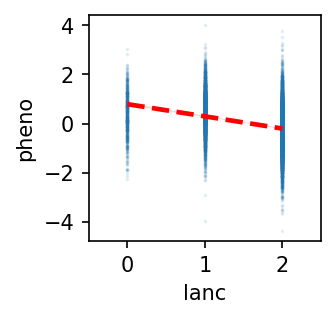

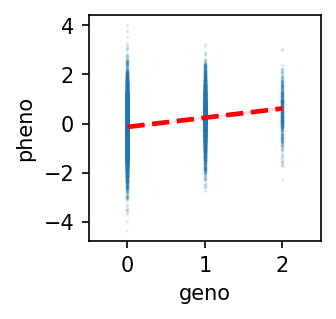

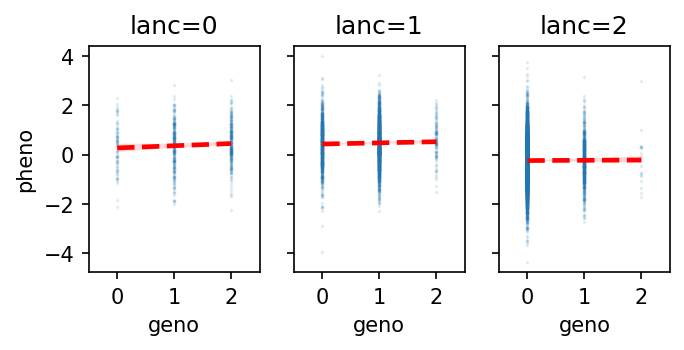

In [26]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
sns.regplot(data=df_plot, x="lanc", y="pheno", ci=95, scatter_kws={"s": 0.5, "alpha": 0.1}, line_kws={"color": "red", "ls": '--'})
print("pheno~lanc", pearsonr(df_plot.pheno, df_plot.lanc))
ax.set_xlim(-0.5, 2.5)

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
sns.regplot(data=df_plot, x="geno", y="pheno", ci=95, scatter_kws={"s": 0.5, "alpha": 0.1}, line_kws={"color": "red", "ls": '--'})
print("pheno~geno", pearsonr(df_plot.pheno, df_plot.geno))

ax.set_xlim(-0.5, 2.5)

fig, axes = plt.subplots(figsize=(5, 2), ncols=3, dpi=150, sharey=True)
for i in range(3):
    sub_df_plot = df_plot[df_plot.lanc == i]
    sns.regplot(data=sub_df_plot, 
                x="geno", y="pheno", ci=95, 
                scatter_kws={"s": 0.5, "alpha": 0.1}, 
                line_kws={"color": "red", "ls": '--'}, 
                ax=axes[i])
    print(f"lanc={i}: pheno~geno", pearsonr(sub_df_plot.pheno, sub_df_plot.geno))
    axes[i].set_xlim(-0.5, 2.5)
    axes[i].set_xticks([0, 1, 2])
    axes[i].set_title(f"lanc={i}")
    if i > 0:
        axes[i].set_ylabel(None)

lanc=0: pheno~geno (-0.23331165328534187, 7.328851561216141e-75)
lanc=1: pheno~geno (-0.25311348988009363, 2.3774716359133883e-38)
lanc=2: pheno~geno (-0.053688696862388724, 0.30700395379867035)


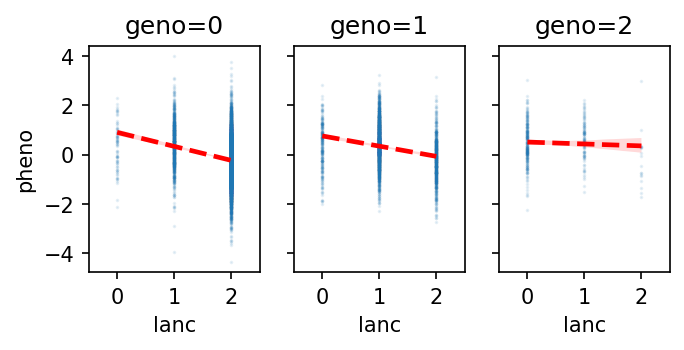

In [25]:
fig, axes = plt.subplots(figsize=(5, 2), ncols=3, dpi=150, sharey=True)
for i in range(3):
    sub_df_plot = df_plot[df_plot.geno == i]
    sns.regplot(data=sub_df_plot, 
                x="lanc", y="pheno", ci=95, 
                scatter_kws={"s": 0.5, "alpha": 0.1}, 
                line_kws={"color": "red", "ls": '--'}, 
                ax=axes[i])
    print(f"lanc={i}: pheno~geno", pearsonr(sub_df_plot.pheno, sub_df_plot.lanc))
    axes[i].set_xlim(-0.5, 2.5)
    axes[i].set_xticks([0, 1, 2])
    axes[i].set_title(f"geno={i}")
    
    if i > 0:
        axes[i].set_ylabel(None)

# TODO:
1. Check literature https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002108 and PAGE paper to define risk regions
2. Spit out ancestry-specific BETA for these risk regions
3. Also construct GRM just on CHR1?